# Welter issue #5
## Predict Teff vs order
### Part 1- Dummy figure

Michael Gully-Santiago  
Monday, December 14, 2015  

Let's try it.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

## Read in all the data.
No spot-checking necessary, since we already did that in the previous notebook.

### IGRINS data of ASASSN15qi

In [3]:
import h5py

In [4]:
f = h5py.File("../data/reduced/LkCa4_IGRINS_K.hdf5", "r")
K = {key:np.array(f[key]) for key in f.keys()}
f.close()

f = h5py.File("../data/reduced/LkCa4_IGRINS_H.hdf5", "r")
H = {key:np.array(f[key]) for key in f.keys()}
f.close()

In [5]:
K['wls'].shape

(26, 2048)

### Telluric absorption

In [6]:
import pandas as pd

In [7]:
tell = pd.read_csv('~/GitHub/plp/master_calib/TelluricModel.dat', sep=' ', names = ['wls', 'trans'])

In [8]:
tell['wls'] = tell['wls'] * 10.0 #convert to angstroms
tell.head()

,wls,trans
0,13999.994558,2.026157e-15
1,14000.024558,1.795465e-15
2,14000.054558,1.657147e-15
3,14000.084558,1.327971e-15
4,14000.114558,1.034897e-15


## Meta

In [9]:
K_orders, H_orders = pd.DataFrame(), pd.DataFrame()

In [10]:
K_orders['wl_start']=[np.floor(min(wl)) for wl in K['wls']]
K_orders['wl_end']=[np.floor(max(wl)) for wl in K['wls']]
K_orders['band']='K'
H_orders['wl_start']=[np.floor(min(wl)) for wl in H['wls']]
H_orders['wl_end']=[np.floor(max(wl)) for wl in H['wls']]
H_orders['band']='H'

In [11]:
orders = H_orders.append(K_orders)

### Calculate average transmission per order

In [12]:
N_orders = len(orders.wl_start)

In [13]:
orders['number'] = orders.index.values

In [14]:
orders.reset_index(inplace=True)

In [15]:
del orders['index']

In [16]:
orders['tell_trans'] = 0.0

In [17]:
for i in range(N_orders):
    ti = (tell.wls > orders.wl_start[i]) & (tell.wls < orders.wl_end[i])
    orders.set_value(i, 'tell_trans', np.mean(tell.trans[ti.values]))

Add the echelle spectral order.

In [18]:
orders['m_val'] = '-'

In [19]:
orders.m_val[orders.band == 'H'] = orders.number + 98
orders.m_val[orders.band == 'K'] = orders.number + 71

In [20]:
orders.head()

,wl_start,wl_end,band,number,tell_trans,m_val
0,18092,18346,H,0,0.117487,98
1,17914,18165,H,1,0.342583,99
2,17739,17988,H,2,0.666035,100
3,17568,17815,H,3,0.827089,101
4,17400,17645,H,4,0.904758,102


## Plot it

In [21]:
sns.set_context('paper', font_scale=1.6)
sns.set_style('ticks')

In [22]:
orders.keys()

Index(['wl_start', 'wl_end', 'band', 'number', 'tell_trans', 'm_val'], dtype='object')

Central wavelength

In [23]:
orders['wl_center'] = (orders.wl_end + orders.wl_start) /2.0

In [24]:
orders.keys()

Index(['wl_start', 'wl_end', 'band', 'number', 'tell_trans', 'm_val',
       'wl_center'],
      dtype='object')

Warmer photosphere

In [25]:
teff_mean = 4100.0
teff_unc  = 100.0
teff_means  = teff_mean * np.ones(N_orders) 
teff_uncs = teff_unc * np.random.normal(size=N_orders)
teff_iid  = teff_means + teff_uncs
teff_unc_het = teff_unc * 1.0 / orders.tell_trans.values
teff_uncs_het = teff_unc_het * np.random.normal(size=N_orders)
teff_het  = teff_means + teff_uncs_het

Cooler photosphere

In [26]:
teff_mean_b = 3500.0
teff_unc_b  = 100.0
teff_means_b  = teff_mean_b * np.ones(N_orders) 
teff_uncs_b = teff_unc_b * np.random.normal(size=N_orders)
teff_iid_b  = teff_means_b + teff_uncs_b
teff_unc_het_b = teff_unc_b * 1.0 / orders.tell_trans.values
teff_uncs_het_b = teff_unc_het_b * np.random.normal(size=N_orders)
teff_het_b  = teff_means_b + teff_uncs_het_b

Plot the telluric spectrum.

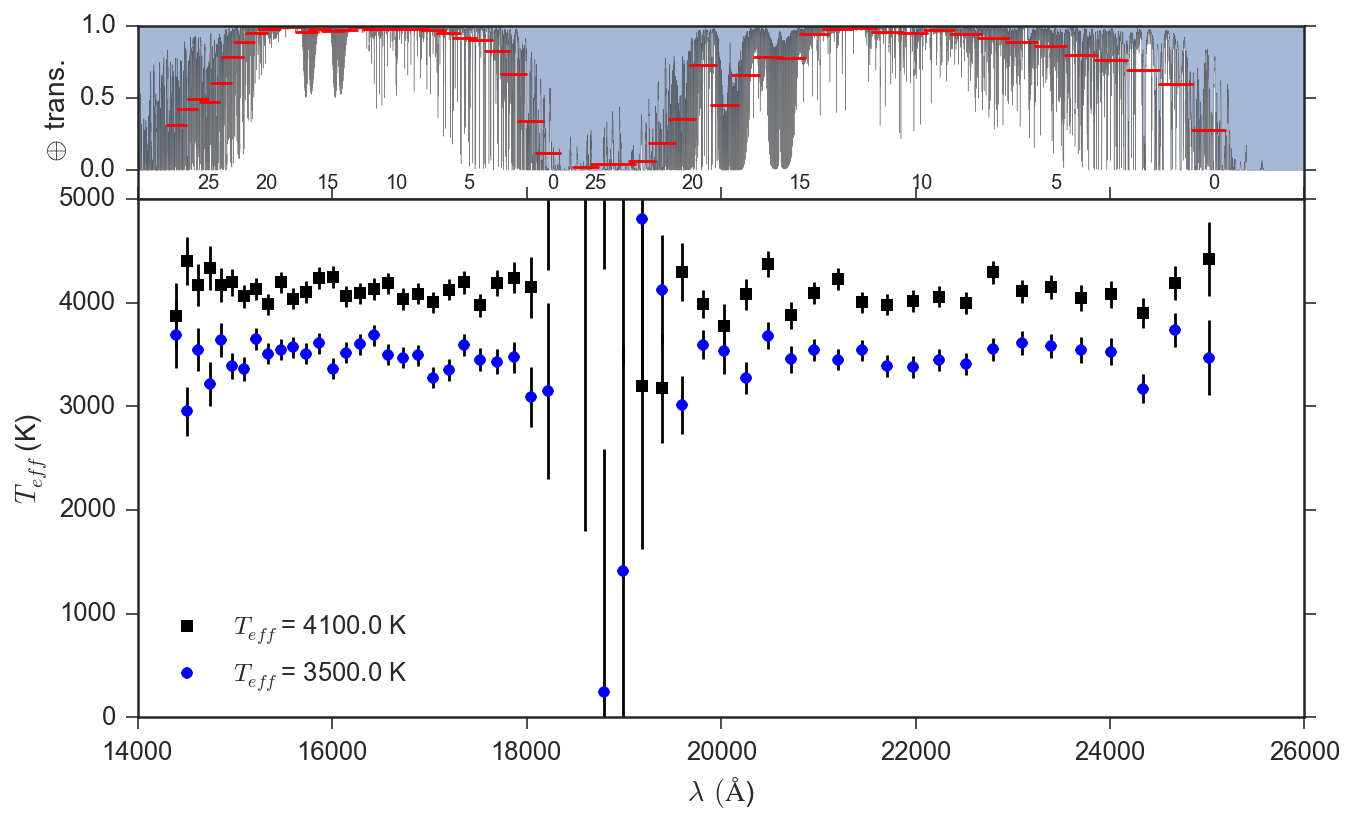

In [27]:
#plt.subplot(211)
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
ax1.fill_between(tell.wls, tell.trans, y2=1.0, alpha=0.5)
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
#text_pos = 500.0 + 20.0*np.arange(N_orders)    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.number.values[i]))
    
    
ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])
label1 = "$T_{eff}$" +" = {} K ".format(teff_mean)
ax.errorbar(orders.wl_center, teff_het, yerr=teff_unc_het, fmt='k.')
ax.plot(orders.wl_center, teff_het, 'ks', label=label1 )

label2 = "$T_{eff}$" +" = {} K ".format(teff_mean_b)
ax.errorbar(orders.wl_center, teff_het_b, yerr=teff_unc_het_b, fmt='k.')
ax.plot(orders.wl_center, teff_het_b, 'bo', label=label2)

ax.set_ylim(0, 5000)
ax.set_xlim(14000, 26000)
ax.set_ylabel('$T_{eff}$ (K)')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

#plt.savefig('../document/figures/teff_vs_order.pdf', bbox_inches='tight')

## Actual data

You can have pandas read the clipboard if you copy the output from the terminal.  Saves a step of copying files over, at the expense of reproducibility...

```python
sf_dat = pd.read_clipboard(names=['m_val', 
                                  'Teff_05p', 'Teff_50p', 'Teff_95p',
                                  'logg_05p', 'logg_50p', 'logg_95p',
                                  'FeH_05p', 'FeH_50p', 'FeH_95p',
                                  'vz_05p', 'vz_50p', 'vz_95p',
                                  'vi_05p', 'vi_50p', 'vi_95p',
                                  'logO_05p', 'logO_50p', 'logO_95p',
                                  'c1_05p', 'c1_50p', 'c1_95p',
                                  'c2_05p', 'c2_50p', 'c2_95p',
                                  'c3_05p', 'c3_50p', 'c3_95p',
                                  'SA_05p', 'SA_50p', 'SA_95p',
                                  'LA_05p', 'LA_50p', 'LA_95p',
                                  'll_05p', 'll_50p', 'll_95p'], sep=r',\s+', squeeze=True)

sf_dat.to_csv('../data/analysis/run01_by_order.csv', index=False)
```

In [86]:
sf_dat = pd.read_csv('../data/analysis/run01_by_order.csv')

In [88]:
sf_dat.head()

,m_val,Teff_05p,Teff_50p,Teff_95p,logg_05p,logg_50p,logg_95p,FeH_05p,FeH_50p,FeH_95p,...,c3_95p,SA_05p,SA_50p,SA_95p,LA_05p,LA_50p,LA_95p,ll_05p,ll_50p,ll_95p
0,76,3500.887964,3512.968506,3557.264307,3.710824,3.919275,3.985384,-0.005136,0.028110,0.147905,...,-0.006600,0.477357,0.522469,0.570479,-1.876134,-1.833403,-1.782990,13.835840,16.166809,18.988152
1,77,3500.795728,3510.691895,3545.161108,3.513734,3.604998,3.699715,-0.239538,-0.185875,-0.110872,...,0.000961,0.390435,0.433180,0.476851,-1.932644,-1.896016,-1.855997,9.851758,11.397231,12.967687
2,78,3500.511963,3507.653809,3533.984521,3.508858,3.619748,3.710764,-0.146219,-0.097723,-0.060084,...,-0.000554,0.437999,0.487495,0.541415,-2.011648,-1.976496,-1.939339,8.734464,10.244488,12.167191
3,79,3500.951147,3513.832275,3550.818262,3.952002,3.986714,3.999206,0.454332,0.491033,0.499401,...,0.003421,0.300208,0.340506,0.385332,-1.977477,-1.944894,-1.910274,7.380616,8.391305,9.610777
4,80,3500.998437,3512.389404,3560.499536,3.511522,3.605421,3.795294,-0.444080,-0.392849,-0.274485,...,-0.000125,0.326830,0.381404,0.441034,-1.961293,-1.924392,-1.883867,10.136391,12.207213,15.230060


In [89]:
merged = pd.merge(orders, sf_dat, on='m_val', how='outer')

merged.head()

,wl_start,wl_end,band,number,tell_trans,m_val,wl_center,Teff_05p,Teff_50p,Teff_95p,...,c3_95p,SA_05p,SA_50p,SA_95p,LA_05p,LA_50p,LA_95p,ll_05p,ll_50p,ll_95p
0,18092,18346,H,0,0.117487,98,18219.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17914,18165,H,1,0.342583,99,18039.5,3501.068994,3513.371826,3552.386816,...,0.033320,4.966462,5.342383,5.683854,-1.801218,-1.722525,-1.645387,21.389151,27.485828,33.448536
2,17739,17988,H,2,0.666035,100,17863.5,3503.000806,3533.342041,3598.625757,...,0.009295,0.561469,0.616338,0.674881,-1.874350,-1.831479,-1.785062,14.759428,16.864183,19.478700
3,17568,17815,H,3,0.827089,101,17691.5,3500.818140,3510.430420,3543.398657,...,0.021796,0.413524,0.454453,0.498684,-1.868368,-1.826906,-1.777924,16.175522,18.257780,21.050026
4,17400,17645,H,4,0.904758,102,17522.5,3501.463135,3521.662598,3629.461426,...,0.009541,0.263719,0.294708,0.326677,-1.862501,-1.813840,-1.750587,17.752643,20.574348,23.989191


## Plot of $T_{eff}$ vs. spectral order

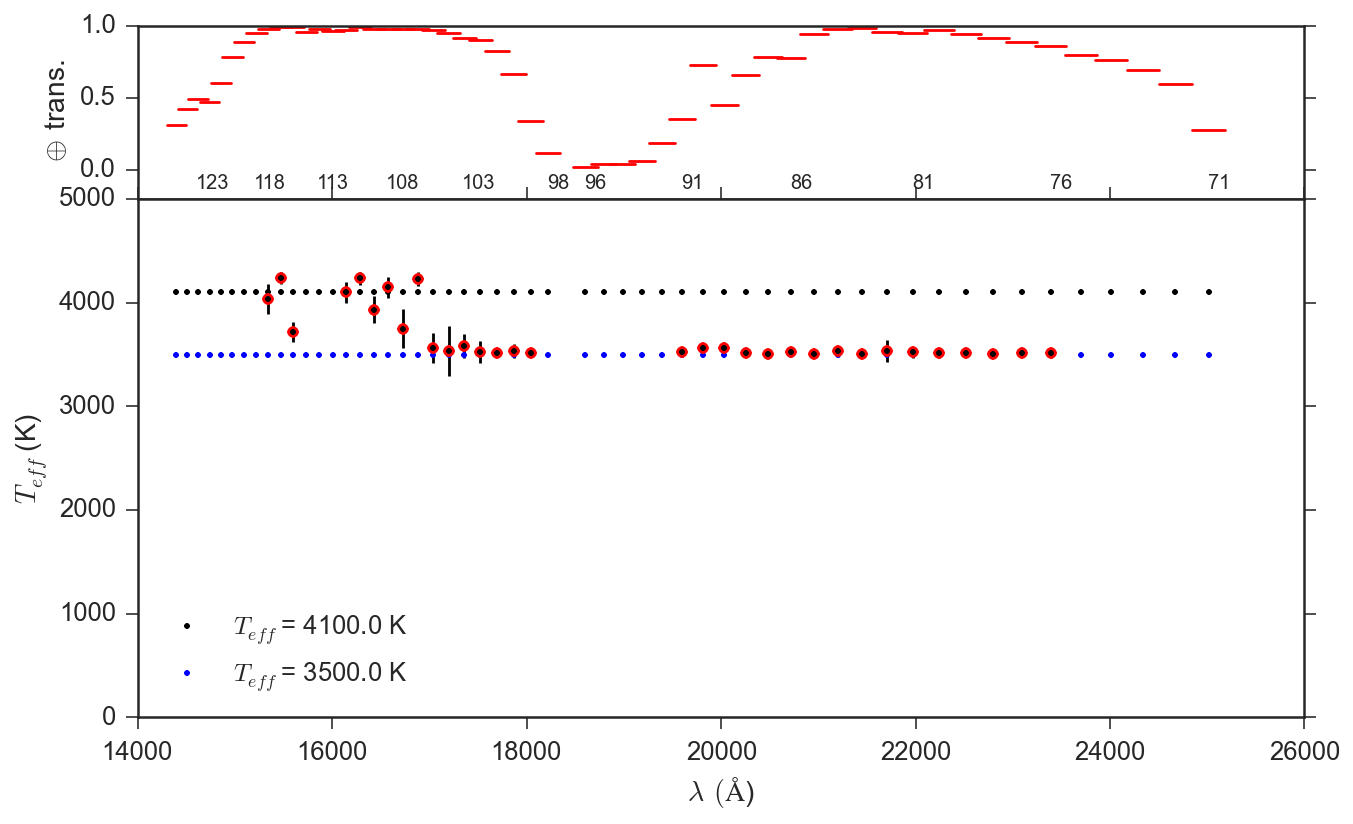

In [90]:

#plt.subplot(211)
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
#ax1.fill_between(tell.wls, tell.trans, y2=1.0, alpha=0.5)
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
#text_pos = 500.0 + 20.0*np.arange(N_orders)    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.m_val.values[i]))
    
    
ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])
label1 = "$T_{eff}$" +" = {} K ".format(teff_mean)
ax.plot(orders.wl_center, [teff_mean]*len(orders.wl_center), 'k.', label=label1)

label2 = "$T_{eff}$" +" = {} K ".format(teff_mean_b)
ax.plot(orders.wl_center, [teff_mean_b]*len(orders.wl_center), 'b.', label=label2)

ax.plot(merged.wl_center, merged.Teff_50p, 'ro')
yerr = merged.Teff_95p - merged.Teff_50p
ax.errorbar(merged.wl_center, merged.Teff_50p, yerr=yerr, fmt='k.')


ax.set_ylim(0, 5000)
ax.set_xlim(14000, 26000)
ax.set_ylabel('$T_{eff}$ (K)')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

plt.savefig('../document/figures/teff_vs_order.pdf', bbox_inches='tight')

## Plot of $\log{g}$ vs. spectral order

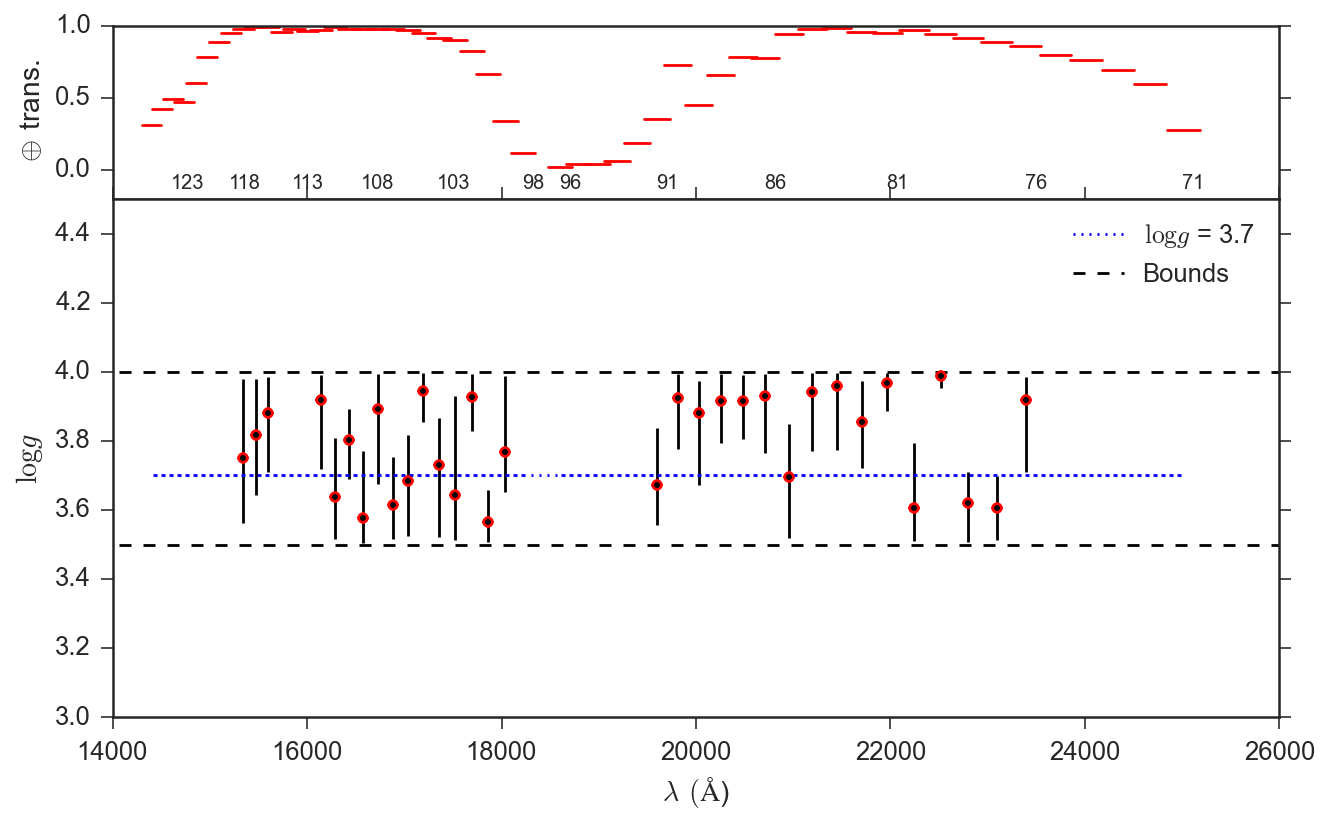

In [91]:

#plt.subplot(211)
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
#ax1.fill_between(tell.wls, tell.trans, y2=1.0, alpha=0.5)
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
#text_pos = 500.0 + 20.0*np.arange(N_orders)    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.m_val.values[i]))

ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])

log_g_mean = 3.7
lglabel = "$\log{g}$" +" = {} ".format(log_g_mean)
ax.plot(orders.wl_center, [3.7]*len(orders.wl_center), 'b:', label=lglabel)

ax.plot([10000, 30000], [3.5]*2, 'k--', label='Bounds')
ax.plot([10000, 30000], [4.0]*2, 'k--')

ax.plot(merged.wl_center, merged.logg_50p, 'ro')
yerr1 = merged.logg_50p - merged.logg_05p
yerr2 = merged.logg_95p - merged.logg_50p
ax.errorbar(merged.wl_center, merged.logg_50p, yerr=[yerr1, yerr2], fmt='k.')


ax.set_ylim(3.0, 4.5)
ax.set_xlim(14000, 26000)
ax.set_ylabel('$\log{g}$')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

#plt.savefig('../document/figures/logg_vs_order.pdf', bbox_inches='tight')

## Plot of $[\mathrm{Fe}/\mathrm{H}]$ vs. spectral order

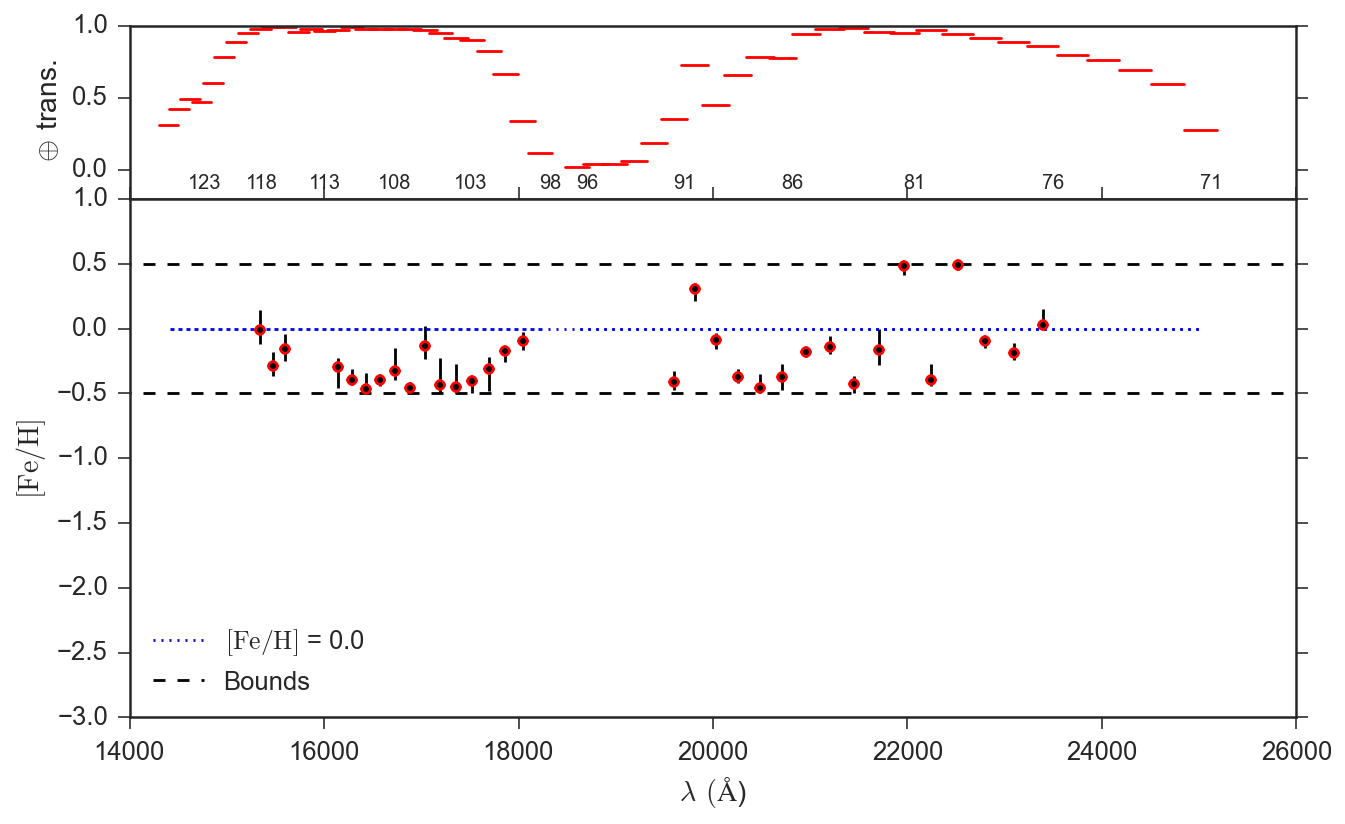

In [92]:

#plt.subplot(211)
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
#ax1.fill_between(tell.wls, tell.trans, y2=1.0, alpha=0.5)
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.m_val.values[i]))

ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])

feh_mean = 0.0
fehlabel = "$[\mathrm{Fe}/\mathrm{H}]$" +" = {} ".format(feh_mean)
ax.plot(orders.wl_center, [feh_mean]*len(orders.wl_center), 'b:', label=fehlabel)

ax.plot([10000, 30000], [-0.5]*2, 'k--', label='Bounds')
ax.plot([10000, 30000], [0.5]*2, 'k--')

ax.plot(merged.wl_center, merged.FeH_50p, 'ro')
yerr1 = merged.FeH_50p - merged.FeH_05p
yerr2 = merged.FeH_95p - merged.FeH_50p
ax.errorbar(merged.wl_center, merged.FeH_50p, yerr=[yerr1, yerr2], fmt='k.')


ax.set_ylim(-3.0, 1.0)
ax.set_xlim(14000, 26000)
ax.set_ylabel('$[\mathrm{Fe}/\mathrm{H}]$')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

#plt.savefig('../document/figures/logg_vs_order.pdf', bbox_inches='tight')

## Plot of $RV$ vs. spectral order

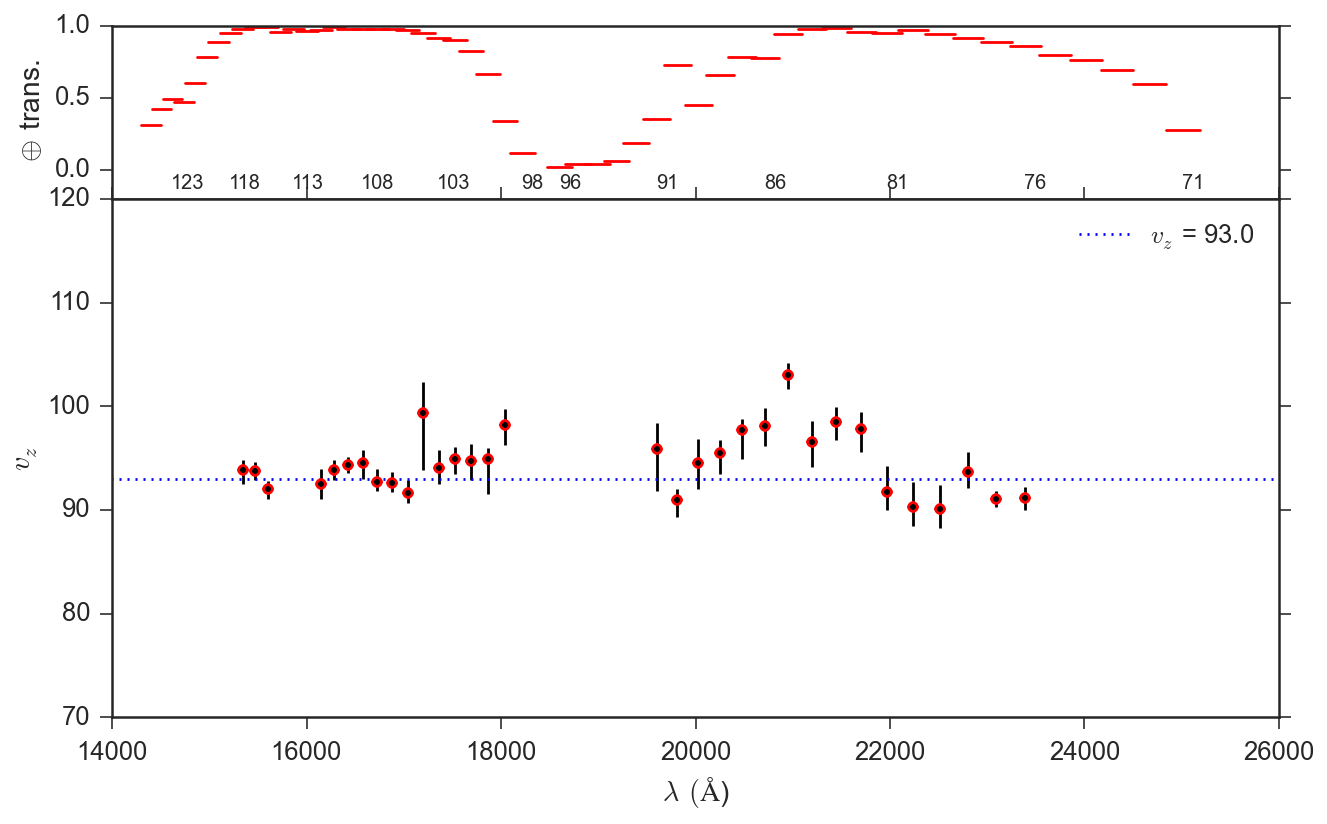

In [93]:

#plt.subplot(211)
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
#ax1.fill_between(tell.wls, tell.trans, y2=1.0, alpha=0.5)
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.m_val.values[i]))

ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])

this_mean = 93.0
thislabel = "$v_z$" +" = {} ".format(this_mean)
ax.plot([10000, 30000], [this_mean]*2, 'b:', label=thislabel)


ax.plot(merged.wl_center, merged.vz_50p, 'ro')
yerr1 = merged.vz_50p - merged.vz_05p
yerr2 = merged.vz_95p - merged.vz_50p
ax.errorbar(merged.wl_center, merged.vz_50p, yerr=[yerr1, yerr2], fmt='k.')


ax.set_ylim(70, 120)
ax.set_xlim(14000, 26000)
ax.set_ylabel('$v_z$')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

#plt.savefig('../document/figures/logg_vs_order.pdf', bbox_inches='tight')

Vsini

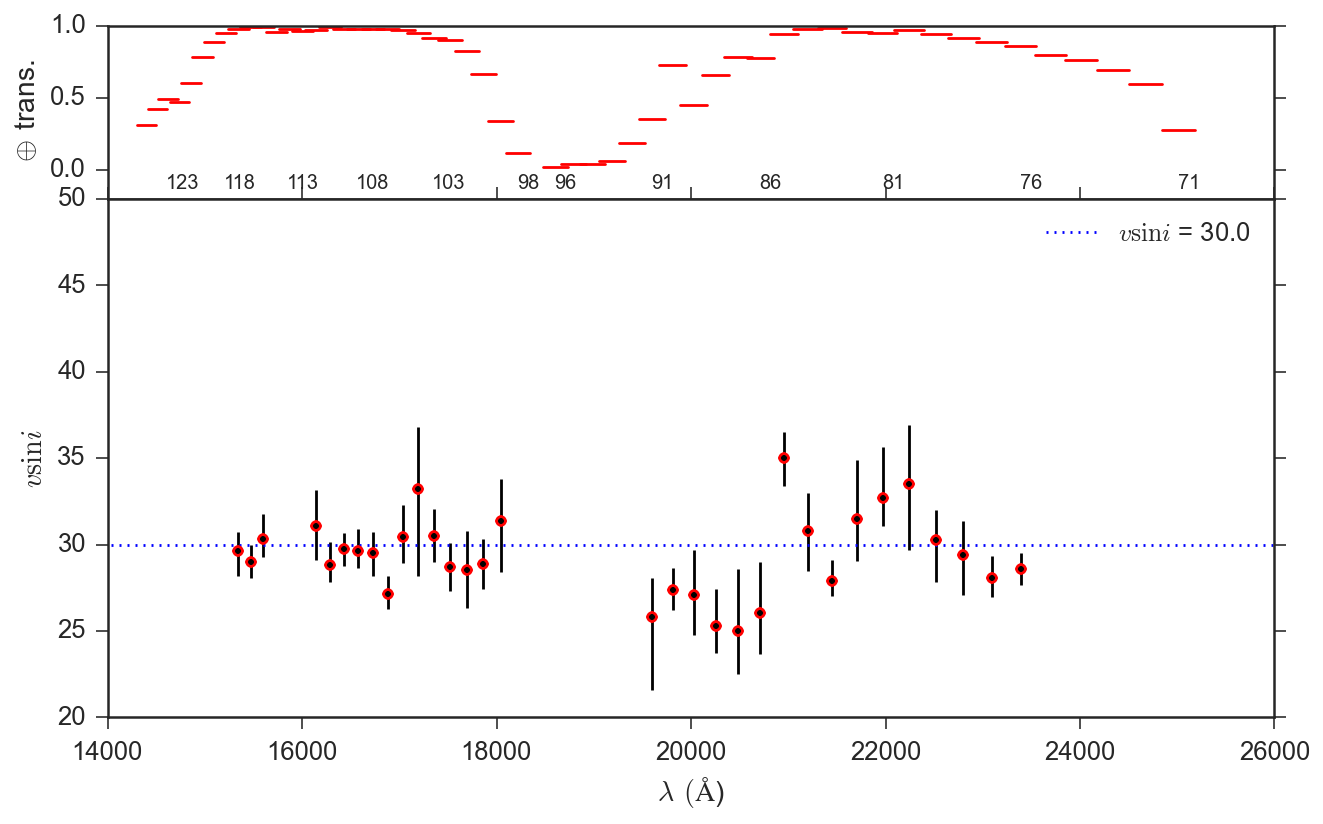

In [94]:

#plt.subplot(211)
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
#ax1.fill_between(tell.wls, tell.trans, y2=1.0, alpha=0.5)
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.m_val.values[i]))

ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])

this_mean = 30.0
thislabel = "$v\sin{i}$" +" = {} ".format(this_mean)
ax.plot([10000, 30000], [this_mean]*2, 'b:', label=thislabel)


ax.plot(merged.wl_center, merged.vi_50p, 'ro')
yerr1 = merged.vi_50p - merged.vi_05p
yerr2 = merged.vi_95p - merged.vi_50p
ax.errorbar(merged.wl_center, merged.vi_50p, yerr=[yerr1, yerr2], fmt='k.')


ax.set_ylim(20, 50)
ax.set_xlim(14000, 26000)
ax.set_ylabel('$v \sin{i}$')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

#plt.savefig('../document/figures/logg_vs_order.pdf', bbox_inches='tight')

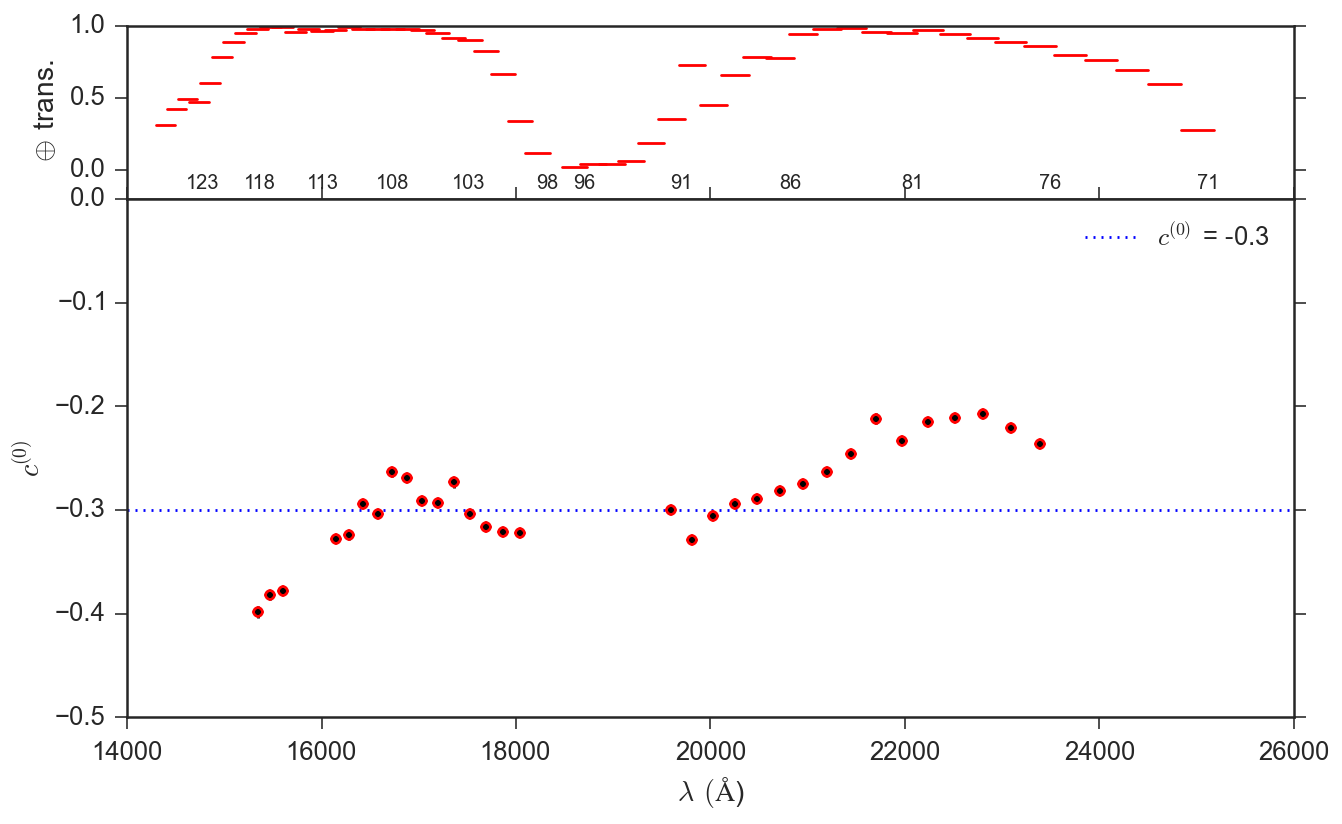

In [98]:
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.m_val.values[i]))

ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])

this_mean = -0.3
this_label = "$c^{(0)}$" +" = {} ".format(this_mean)
ax.plot([10000, 30000], [this_mean]*2, 'b:', label=this_label)

x = merged.wl_center
y = merged.logO_50p
y05 = merged.logO_05p
y95 = merged.logO_95p
ax.plot(x, y, 'ro')
yerr1 = y - y05
yerr2 = y95 - y
ax.errorbar(x, y, yerr=[yerr1, yerr2], fmt='k.')


ax.set_ylim(-0.5, 0.0)
ax.set_xlim(14000, 26000)
ax.set_ylabel('$c^{(0)}}$')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

#plt.savefig('../document/figures/logg_vs_order.pdf', bbox_inches='tight')

# Order-by-order calibration parameters

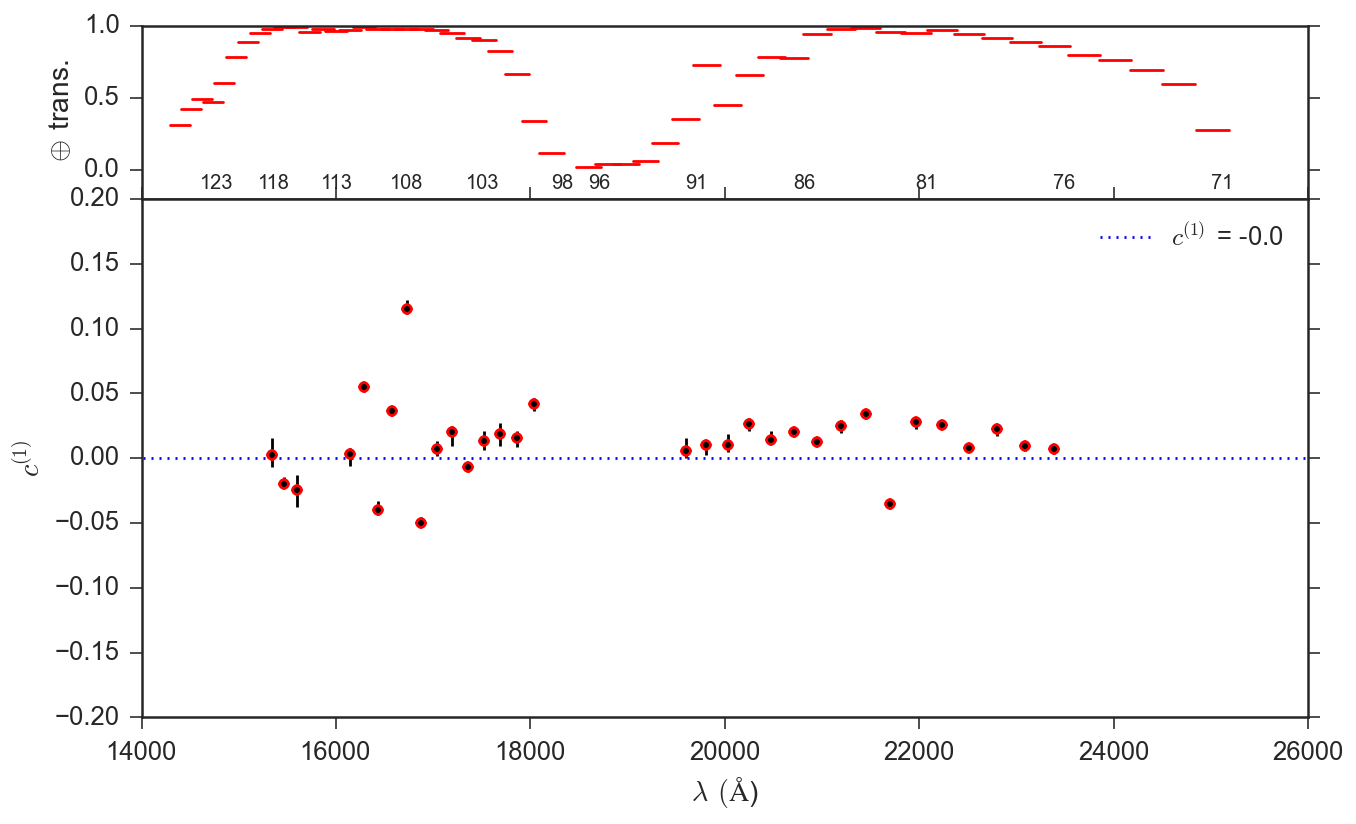

In [101]:
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.m_val.values[i]))

ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])

this_mean = -0.0
this_label = "$c^{(1)}$" +" = {} ".format(this_mean)
ax.plot([10000, 30000], [this_mean]*2, 'b:', label=this_label)

x = merged.wl_center
y = merged.c1_50p
y05 = merged.c1_05p
y95 = merged.c1_95p
ax.plot(x, y, 'ro')
yerr1 = y - y05
yerr2 = y95 - y
ax.errorbar(x, y, yerr=[yerr1, yerr2], fmt='k.')


ax.set_ylim(-0.2, 0.2)
ax.set_xlim(14000, 26000)
ax.set_ylabel('$c^{(1)}}$')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

#plt.savefig('../document/figures/logg_vs_order.pdf', bbox_inches='tight')

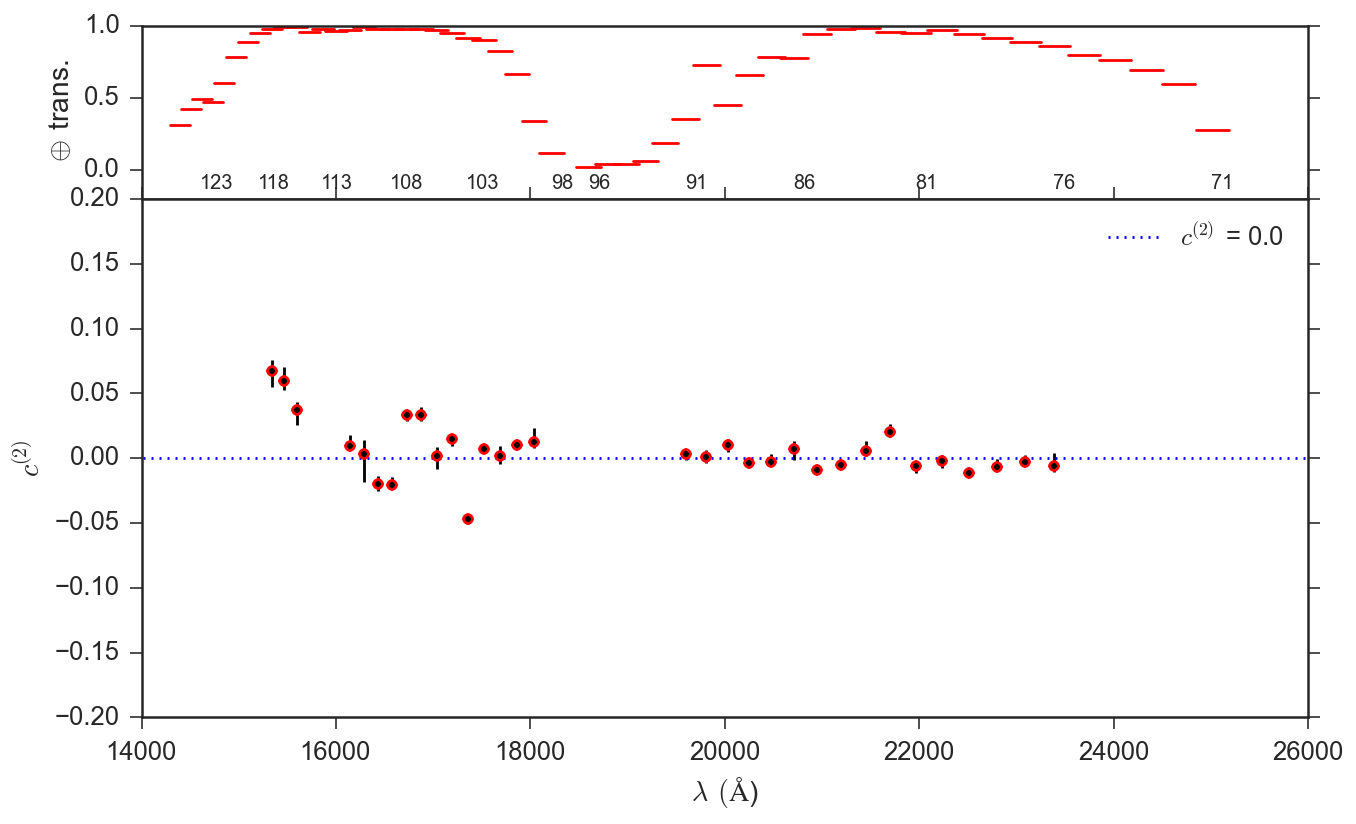

In [102]:
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.m_val.values[i]))

ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])

this_mean = 0.0
this_label = "$c^{(2)}$" +" = {} ".format(this_mean)
ax.plot([10000, 30000], [this_mean]*2, 'b:', label=this_label)

x = merged.wl_center
y = merged.c2_50p
y05 = merged.c2_05p
y95 = merged.c2_95p
ax.plot(x, y, 'ro')
yerr1 = y - y05
yerr2 = y95 - y
ax.errorbar(x, y, yerr=[yerr1, yerr2], fmt='k.')


ax.set_ylim(-0.2, 0.2)
ax.set_xlim(14000, 26000)
ax.set_ylabel('$c^{(2)}}$')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

#plt.savefig('../document/figures/logg_vs_order.pdf', bbox_inches='tight')

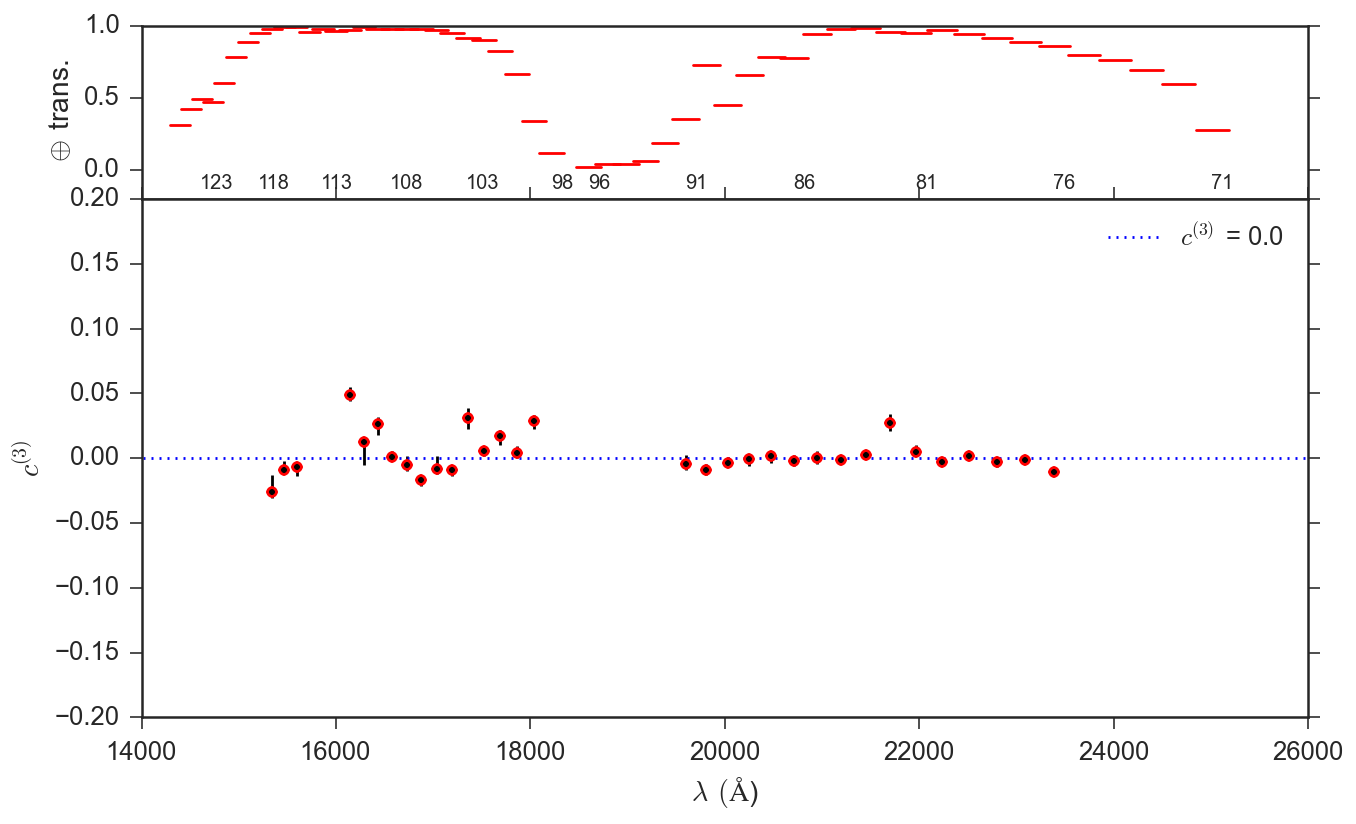

In [104]:
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.m_val.values[i]))

ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])

this_mean = 0.0
this_label = "$c^{(3)}$" +" = {} ".format(this_mean)
ax.plot([10000, 30000], [this_mean]*2, 'b:', label=this_label)

x = merged.wl_center
y = merged.c3_50p
y05 = merged.c3_05p
y95 = merged.c3_95p
ax.plot(x, y, 'ro')
yerr1 = y - y05
yerr2 = y95 - y
ax.errorbar(x, y, yerr=[yerr1, yerr2], fmt='k.')


ax.set_ylim(-0.2, 0.2)
ax.set_xlim(14000, 26000)
ax.set_ylabel('$c^{(3)}}$')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

#plt.savefig('../document/figures/logg_vs_order.pdf', bbox_inches='tight')

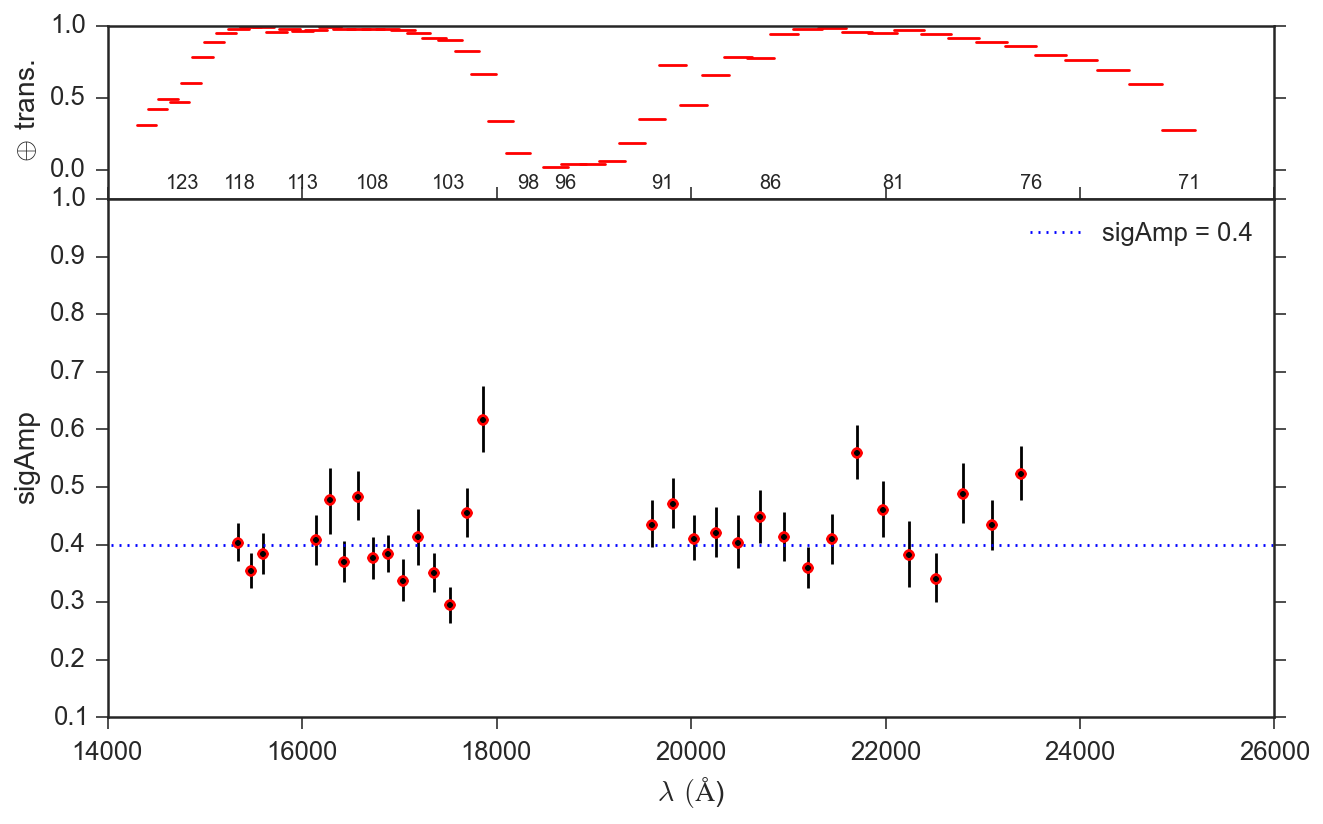

In [108]:
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.m_val.values[i]))

ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])

this_mean = 0.4
this_label = "sigAmp" +" = {} ".format(this_mean)
ax.plot([10000, 30000], [this_mean]*2, 'b:', label=this_label)

x = merged.wl_center
y = merged.SA_50p
y05 = merged.SA_05p
y95 = merged.SA_95p
ax.plot(x, y, 'ro')
yerr1 = y - y05
yerr2 = y95 - y
ax.errorbar(x, y, yerr=[yerr1, yerr2], fmt='k.')


ax.set_ylim(0.1, 1.0)
ax.set_xlim(14000, 26000)
ax.set_ylabel('sigAmp')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

#plt.savefig('../document/figures/logg_vs_order.pdf', bbox_inches='tight')

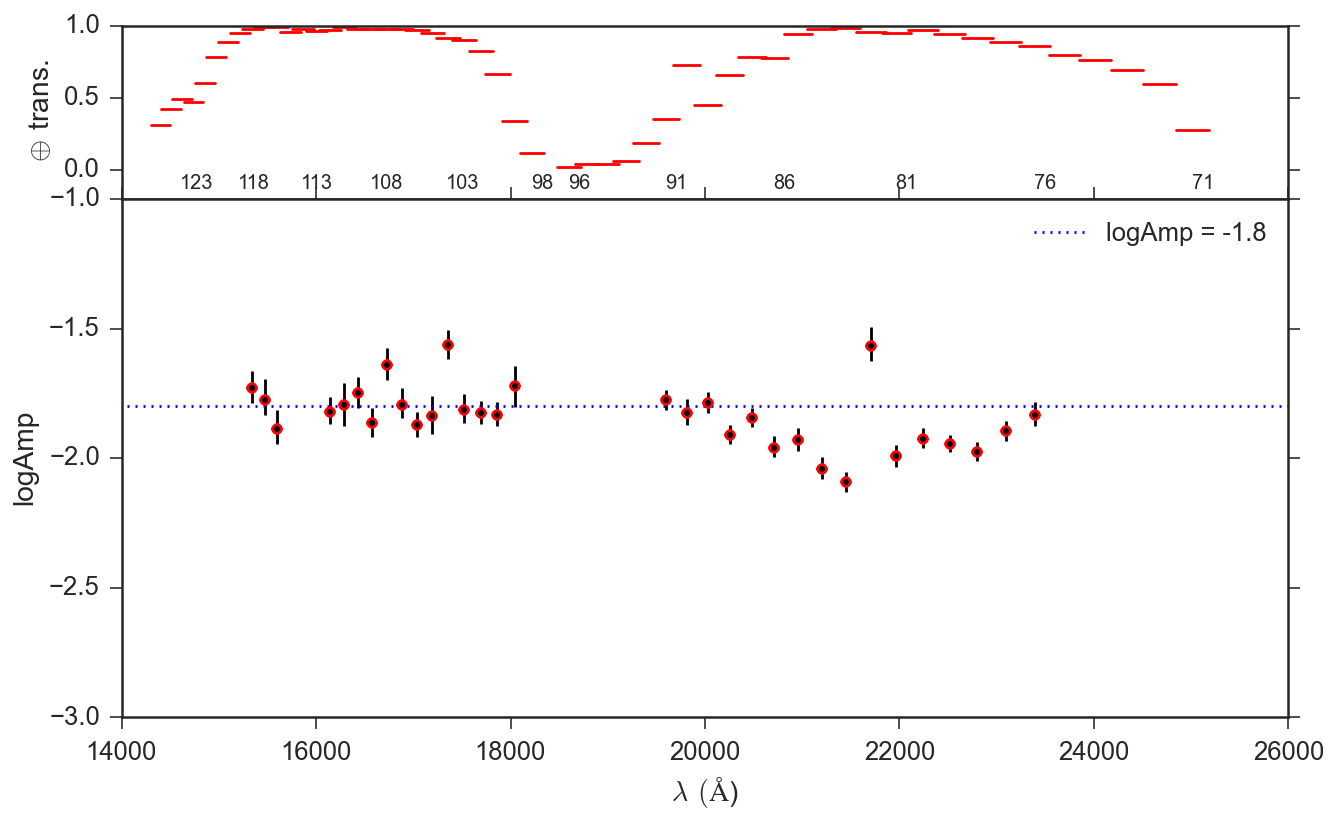

In [110]:
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.m_val.values[i]))

ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])

this_mean = -1.8
this_label = "logAmp" +" = {} ".format(this_mean)
ax.plot([10000, 30000], [this_mean]*2, 'b:', label=this_label)

x = merged.wl_center
y = merged.LA_50p
y05 = merged.LA_05p
y95 = merged.LA_95p
ax.plot(x, y, 'ro')
yerr1 = y - y05
yerr2 = y95 - y
ax.errorbar(x, y, yerr=[yerr1, yerr2], fmt='k.')


ax.set_ylim(-3, -1.0)
ax.set_xlim(14000, 26000)
ax.set_ylabel('logAmp')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

#plt.savefig('../document/figures/logg_vs_order.pdf', bbox_inches='tight')

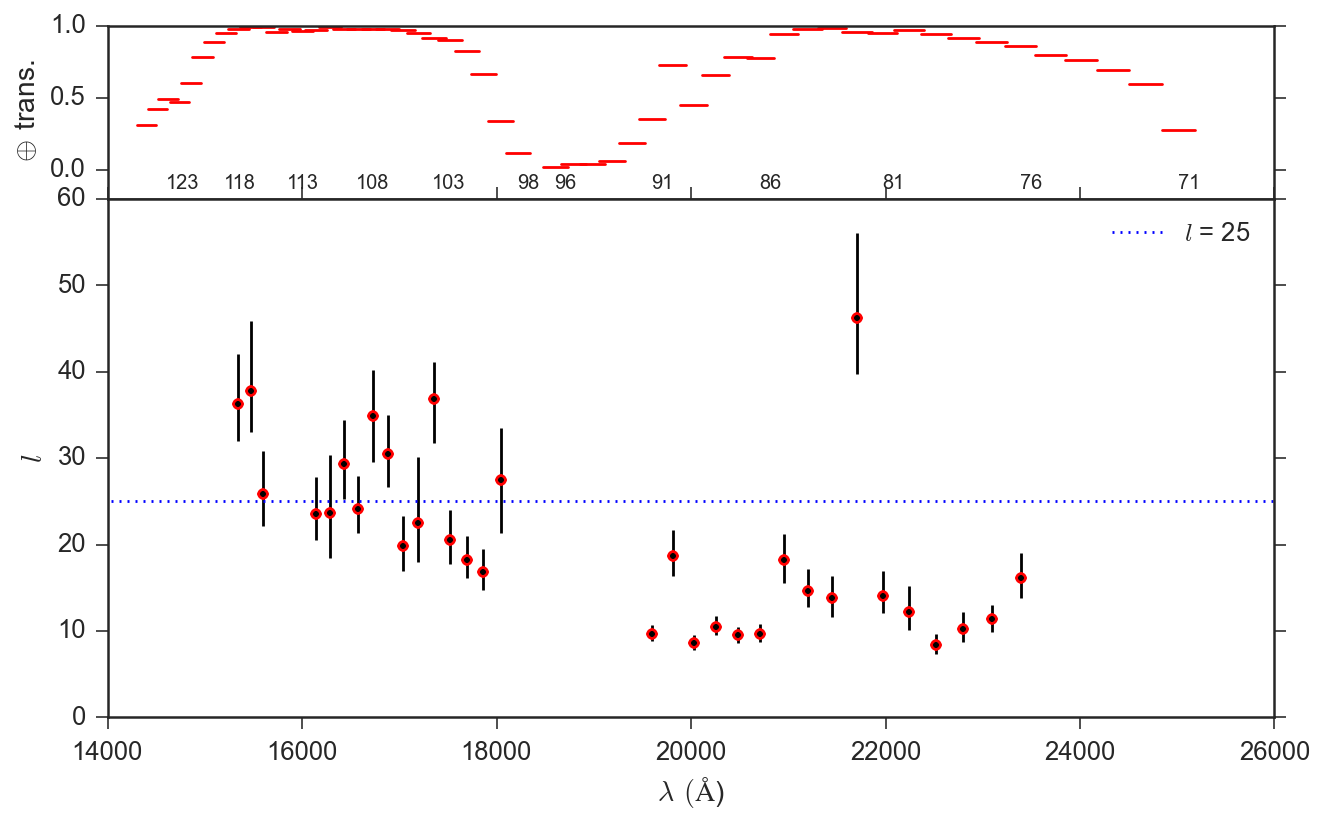

In [116]:
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.35, 0.7, 0.45, 0.2],xticks=[], yticks=[0.0, 0.5, 1])
ax1.set_xlim(14000, 26000)
ax1.set_ylim(-0.2, 1)
ax1.set_ylabel('$\oplus$ trans.')
for i in range(N_orders):
    x = [orders.wl_start[i], orders.wl_end[i]]
    y = [orders.tell_trans[i]]*2
    ax1.plot(x, y, 'r-')
    
for i in range(N_orders):
    if (orders.number.values[i] % 5) == 0:
        ax1.text(orders.wl_center[i], -0.13, '{}'.format(orders.m_val.values[i]))

ax = fig.add_axes([0.35, 0.1, 0.45, 0.6])

this_mean = 25
this_label = "$l$" +" = {} ".format(this_mean)
ax.plot([10000, 30000], [this_mean]*2, 'b:', label=this_label)

x = merged.wl_center
y = merged.ll_50p
y05 = merged.ll_05p
y95 = merged.ll_95p
ax.plot(x, y, 'ro')
yerr1 = y - y05
yerr2 = y95 - y
ax.errorbar(x, y, yerr=[yerr1, yerr2], fmt='k.')


ax.set_ylim(0, 60)
ax.set_xlim(14000, 26000)
ax.set_ylabel('$l$')
ax.set_xlabel('$\lambda \,(\AA $)')
ax.legend(loc='best')

#plt.savefig('../document/figures/logg_vs_order.pdf', bbox_inches='tight')

Par-par plot

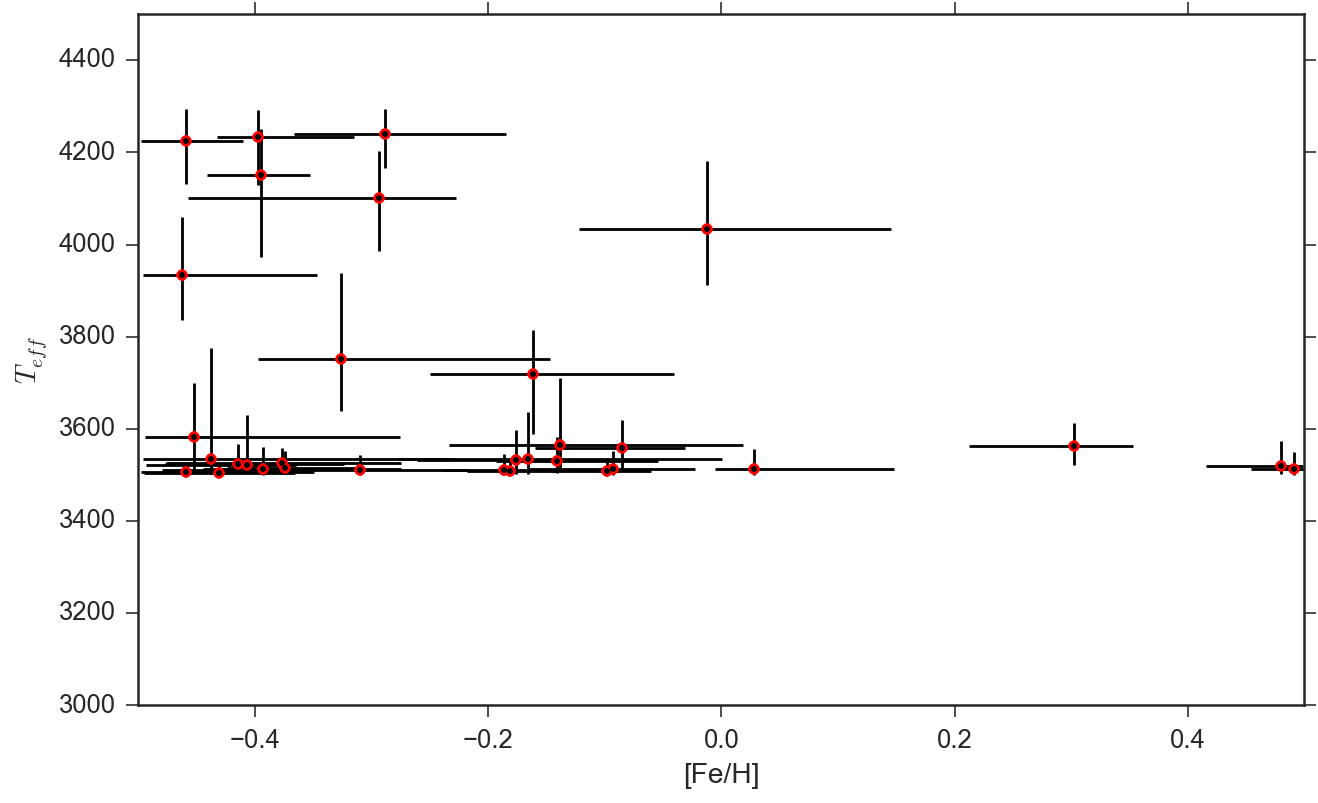

In [96]:

#plt.subplot(211)
fig = plt.figure(figsize=(18, 6))

ax = fig.add_axes([0.35, 0.1, 0.45, 0.8])




ax.plot(merged.FeH_50p, merged.Teff_50p, 'ro')
yerr1 = merged.Teff_50p - merged.Teff_05p
yerr2 = merged.Teff_95p - merged.Teff_50p
xerr1 = merged.FeH_50p - merged.FeH_05p
xerr2 = merged.FeH_95p - merged.FeH_50p
ax.errorbar(merged.FeH_50p, merged.Teff_50p, yerr=[yerr1, yerr2], xerr=[xerr1, xerr2], fmt='k.')


ax.set_xlim(-0.5, 0.5)
ax.set_ylim(3000, 4500)
ax.set_ylabel('$T_{eff}$')
ax.set_xlabel('[Fe/H]')
ax.legend(loc='best')

#plt.savefig('../document/figures/logg_vs_order.pdf', bbox_inches='tight')

# Save the merged DataFrame

In [117]:
merged.to_csv('../data/analysis/IGRINS_LkCa4_run01_last20kMCMC.csv', index=False)

The end for now.  